In [1]:
import os
import numpy as np
import shutil
import time
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision as tv
import nntools as nt
import torch
import torch.utils.data as data

from models import *
from preprocess import *

In [2]:
# will take a few minutes to load

images_dir = '/datasets/ee285f-public/VQA2017/'
q_dir = '/datasets/ee285f-public/VQA2017/v2_OpenEnded_mscoco_'
ans_dir = '/datasets/ee285f-public/VQA2017/v2_mscoco_'

train_set = MSCOCODataset(images_dir, q_dir, 
                          ans_dir, mode='train', 
                          image_size=(224, 224))

10100


In [9]:
class ExperimentLoader():
    def __init__(self, input_dir, train_set, batch_size):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.train_set = train_set
        self.inv_q = {v: k for k, v in self.train_set.vocab_q.items()} 
        self.inv_a = {v: k for k, v in self.train_set.vocab_a.items()} 
        
        self.image_model = VGGNet(output_features=1024).to(self.device)
        self.question_model = LSTM(vocab_size=len(self.train_set.vocab_q), embedding_dim=1000,
                                   batch_size=batch_size, hidden_dim=1024).to(self.device)
        self.attention = AttentionNet(num_classes=1000, batch_size=batch_size,
                                      input_features=1024, output_features=512).to(self.device)
        
        self.optimizer_parameter_group = [{'params': self.question_model.parameters()}, 
                                          {'params': self.image_model.parameters()},
                                          {'params': self.attention.parameters()}]
        
        self.optimizer = torch.optim.RMSprop(self.optimizer_parameter_group,
                                             lr=4e-4, alpha=0.99, eps=1e-8, momentum=0.9)
        self.batch_size = None
        self.history = None
        self.train_loss = None
        self.train_acc = None
        self.train_ind = None
        
        os.makedirs(input_dir, exist_ok=True)
        self.checkpoint_path = os.path.join(input_dir, 
                                       "checkpoint.pth.tar")
        self.config_path = os.path.join(input_dir, "config.txt")
        
        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)
        
        if os.path.isfile(self.config_path):
            self.load()
    
    def sample(self, idx):
        self.image_model = self.image_model.to(self.device)
        self.question_model = self.question_model.to(self.device)
        self.attention = self.attention.to(self.device)
        
        self.image_model.eval()
        self.question_model.eval()
        self.attention.eval()
        
        with torch.no_grad():
            entry = self.train_set[idx]

            i, q, s, a = entry[0].to(self.device), entry[1].to(self.device), \
                         entry[2], entry[3].to(self.device)
            
            myimshow(i)
            
            question = []
            for index in range(s):
                question.append(self.inv_q[int(entry[1][index])])
            
            i = i.unsqueeze(dim=0)
            q = q.unsqueeze(dim=0)
            s = torch.Tensor([s])
            
            image_embed = self.image_model(i)
            question_embed = self.question_model(q.long(), s.long())
            output = self.attention(image_embed, question_embed)
            
            _, y_pred = torch.max(output, 1)
            
            print("Question:", ' '.join(question), "--> Answer:", self.inv_a[int(y_pred)]) 
    
    @property
    def epoch(self):
        return len(self.history)

    def setting(self):
        return {'ImageModel': self.image_model,
                'QuestionModel' : self.question_model,
                'AttentionModel' : self.attention,
                'Train Set': self.train_set,
                'Optimizer': self.optimizer,
                'BatchSize': self.batch_size}
    
    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string
    
    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'ImageModel': self.image_model.state_dict(),
                'QuestionModel' : self.question_model.state_dict(),
                'AttentionModel' : self.attention.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history,
                'TrainLoss' : self.train_loss,
                'TrainAcc' : self.train_acc,
                'Indices' : self.train_ind}
    
    def load_state_dict(self, checkpoint):
        self.image_model.load_state_dict(checkpoint['ImageModel'])
        self.question_model.load_state_dict(checkpoint['QuestionModel'])
        self.attention.load_state_dict(checkpoint['AttentionModel'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']
        self.train_loss = checkpoint['TrainLoss']
        self.train_acc = checkpoint['TrainAcc']
        self.train_ind = checkpoint['Indices']
        
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.device)
        self.load_state_dict(checkpoint)
        del checkpoint

In [10]:
exp = ExperimentLoader(train_set=train_set, batch_size=200, input_dir="exp_batch200")

Note: rerunning the following cells might change the image/question/answer, since the training set is loaded randomly.

Question: has a bite been taken --> Answer: beef


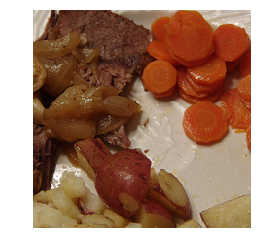

In [23]:
exp.sample(exp.train_ind[7])

Question: are the dogs thirsty --> Answer: very


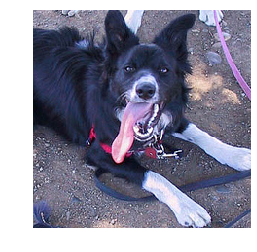

In [18]:
exp.sample(exp.train_ind[10])

Question: is the dog taking a nap --> Answer: yes


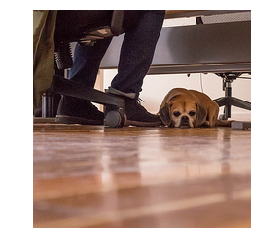

In [20]:
exp.sample(exp.train_ind[901])

Question: is the snow deep --> Answer: yes


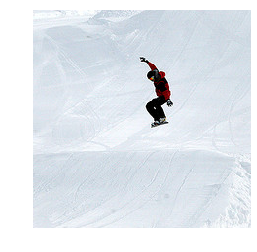

In [22]:
exp.sample(exp.train_ind[1847])